The full codebase is available at https://github.com/minhduc0711/aml-challenge-3/. 
This is only the notebook for fine-tuning BERTweet, our best-performing approach.

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer
from src.features.preprocess import preprocess

tokenizer_tweet = TweetTokenizer()


def normalizeToken(token):
    if len(token) == 1:
        token = demojize(token)
    return token

def normalizeTweet(tweet):
    tokens = tokenizer_tweet.tokenize(tweet.replace("’", "'").replace("…", "...").replace("`", "'"))

    normTweet = " ".join([normalizeToken(token) for token in tokens])
    normTweet = preprocess(normTweet)

    return " ".join(normTweet.split())

text = "i hope my morning show doesn`t get cancelled!"
normalizeTweet(text)

'i hope my morning show does not get cancelled'

In [25]:
from transformers import AutoTokenizer
import os

MODEL_NAME = "vinai/bertweet-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

os.environ["TOKENIZERS_PARALLELISM"] = "false"
def tokenize_function(examples):
    return tokenizer.encode_plus(examples, 
                                 padding="max_length", max_length=40, truncation=True,
                                add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
                                return_attention_mask=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [19]:
from src.data.data_module import TextDataModule
from src.features.preprocess import preprocess

dm = TextDataModule(preprocess_fn=normalizeTweet, vectorizer_fn=tokenize_function, tokenize_fn=None, 
                    batch_size=8, 
                    num_workers=8)

In [26]:
import torch
import torch.nn as nn
import torchmetrics
import pytorch_lightning as pl

from transformers import get_scheduler
from transformers import AutoModel

class BERTClassifier(pl.LightningModule):
    def __init__(self, num_training_steps, num_labels=3, h_dim=50):
        super().__init__()
        
        
        self.num_training_steps = num_training_steps
        # self.batch_keys_keep = ['labels', y'input_ids', 'token_type_ids', 'attention_mask']
        self.batch_keys_keep = ['input_ids', 'token_type_ids', 'attention_mask']
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.classifier = nn.Sequential(
            nn.Linear(768, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, num_labels)
        )
        
        # self.loss_fn = nn.CrossEntropyLoss(label_smoothing=0.0)
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy()
        
    def forward(self, x):
        x = self.bert(**x)[1]
        return self.classifier(x)
        
    def training_step(self, batch, batch_idx):
        y = batch["labels"]
        batch = self.filter_batch(batch)
        y_hat = self(batch)
        
        loss = self.loss_fn(y_hat, y)
        acc = self.accuracy(y_hat, y)
        
        self.log("train/loss", loss)
        self.log("train/acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        y = batch["labels"] 
        batch = self.filter_batch(batch)
        y_hat = self(batch)
        
        val_loss = self.loss_fn(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("val/loss", val_loss)
        self.log("val/acc", acc)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
        lr_scheduler = get_scheduler(
            name="linear", optimizer=optimizer, num_warmup_steps=0, 
            num_training_steps=self.num_training_steps
        )

        return [optimizer], [lr_scheduler]
                
    def filter_batch(self, batch):
        return {k: batch[k] for k in batch.keys() if k in self.batch_keys_keep}
    
num_epochs = 2
num_training_steps = num_epochs * len(dm.train_dataloader())

model = BERTClassifier(num_training_steps, h_dim=100)
logger = pl.loggers.TensorBoardLogger("lightning_logs", name="bertweet-label-smooth")
trainer = pl.Trainer(accelerator="gpu",
                     logger=logger,
                     max_epochs=num_epochs,
                     enable_checkpointing=False,
                    )
trainer.fit(model=model, datamodule=dm)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
-----------------------------------

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

In [27]:
from tqdm.auto import tqdm
import torch.nn.functional as F
preds = []
actuals = []
probas = []
model.eval()
model.cuda()
for batch in tqdm(dm.val_dataloader()):
    with torch.no_grad():
        actuals.append(batch["labels"])
        batch = model.filter_batch(batch)
        batch = {k: v.cuda() for k,v in batch.items()}
        outputs = model(batch)
        preds.append(torch.argmax(outputs, dim=1))

        probas.append(F.softmax(outputs, dim=1))

preds = torch.cat(preds)
actuals = torch.cat(actuals)
probas = torch.cat(probas)

  0%|          | 0/619 [00:00<?, ?it/s]

0.7978164173069147


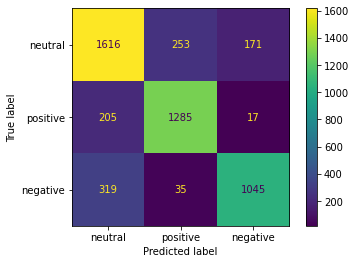

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

labels = ["neutral", "positive", "negative"]
cm = confusion_matrix(actuals.cpu().numpy(), preds.cpu().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
print(accuracy_score(actuals.cpu(), preds.cpu()))

In [49]:
idx = 49
probas[idx], dm.subsets["val"][idx]

(tensor([0.0184, 0.9777, 0.0040], device='cuda:0'),
 {'text': 'Repeat final seconds of Game 3 Dal-Den please! **** THOSE OFFICIALS. :| Anyway, happy mothers day.',
  'labels': tensor(0),
  'preproc_text': 'repeat final seconds of game dal den please those officials anyway happy mothers day',
  'input_ids': tensor([    0,  4116,  1222,  1971,    15,   212, 27789,  2745,   183,   268,
           5215,  1361,   225,  7869,    93,     2,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1]),
  'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])})

In [36]:
import numpy as np
np.where((preds.cpu().numpy() == 1) & (actuals.cpu().numpy() == 0) )

(array([  23,   33,   44,   49,   95,   96,  122,  147,  180,  183,  206,
         209,  210,  213,  227,  270,  275,  335,  336,  366,  374,  385,
         434,  443,  452,  474,  475,  487,  503,  526,  533,  541,  565,
         573,  587,  599,  619,  635,  689,  706,  767,  776,  812,  822,
         826,  855,  860,  868,  875,  884,  888,  907,  916,  934,  947,
         974, 1010, 1017, 1023, 1039, 1058, 1065, 1069, 1102, 1108, 1163,
        1165, 1198, 1209, 1233, 1324, 1326, 1335, 1339, 1393, 1395, 1403,
        1456, 1491, 1505, 1513, 1525, 1533, 1578, 1604, 1618, 1649, 1650,
        1718, 1732, 1742, 1750, 1752, 1795, 1797, 1846, 1853, 1874, 1875,
        1914, 1944, 1959, 1980, 2018, 2041, 2043, 2131, 2156, 2162, 2208,
        2213, 2226, 2260, 2264, 2278, 2281, 2284, 2295, 2311, 2320, 2326,
        2335, 2343, 2349, 2403, 2405, 2418, 2432, 2452, 2453, 2480, 2489,
        2506, 2546, 2577, 2585, 2603, 2609, 2620, 2630, 2664, 2673, 2676,
        2697, 2698, 2703, 2766, 2783, 

In [45]:
probas[true_pos_idxs, 1].cpu().numpy().squeeze()

array([0.99245185, 0.99223775, 0.99237627, ..., 0.99248815, 0.96083903,
       0.99324   ], dtype=float32)

<AxesSubplot:ylabel='Count'>

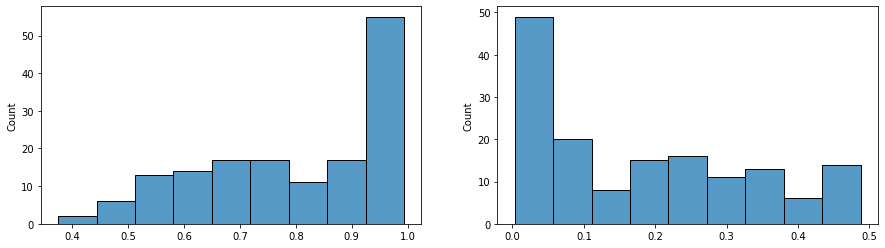

In [55]:
true_pos_idxs = np.where((preds.cpu().numpy() == 1) & (actuals.cpu().numpy() == 0))
p_pos = probas[true_pos_idxs, 1].cpu().numpy().squeeze()
p_neu = probas[true_pos_idxs, 0].cpu().numpy().squeeze()
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
sns.histplot(p_pos, ax=axs[0])
sns.histplot(p_neu, ax=axs[1])

In [7]:
from tqdm.auto import tqdm
preds_test = []
model.cuda()
model.eval()
for batch in tqdm(dm.test_dataloader()):
    with torch.no_grad():
        batch = model.filter_batch(batch)
        batch = {k: v.cuda() for k,v in batch.items()}
        outputs = model(batch)
        preds_test.append(torch.argmax(outputs, dim=1))
preds_test = torch.cat(preds_test)

  0%|          | 0/344 [00:00<?, ?it/s]

In [8]:
import pandas as pd
df_test = pd.read_csv("../data/raw/test.csv")
df_test.head()

,textID,text,selected_text
0,102f98e5e2,Happy Mother`s Day hahaha,Happy Mother`s Day
1,033b399113,"Sorry for the triple twitter post, was having ...","Sorry for the triple twitter post, was having ..."
2,c125e29be2,thats much better than the flu syndrome!,thats much better
3,b91e2b0679,Aww I have a tummy ache,tummy ache
4,1a46141274,hey chocolate chips is good. i want a snack ...,good.


In [9]:
from src.utils import create_submission
create_submission(df_test, preds_test.cpu())

In [11]:
!kaggle competitions submit -c eurecom-aml-2022-challenge-3 -f submission.csv -m "BERTweet with full train set"

100%|██████████████████████████████████████| 35.6k/35.6k [00:00<00:00, 75.0kB/s]
Successfully submitted to EURECOM AML 2022:: Challenge 3